In [81]:
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import tensorflow
from tensorflow.keras.callbacks import TensorBoard
from medmnist import PneumoniaMNIST
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Importar la data

In [3]:
trainX = PneumoniaMNIST(
    split="train",
    download=True
);

validX = PneumoniaMNIST(
    split="val",
    download=True
);

testX = PneumoniaMNIST(
    split="test",
    download=True
);

Using downloaded and verified file: /home/cgarretes/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/cgarretes/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/cgarretes/.medmnist/pneumoniamnist.npz


In [4]:
trainY = trainX.labels
validY = validX.labels
testY = testX.labels

# Analizamos los datos

In [5]:
trainX, validX, testX

(Dataset PneumoniaMNIST (pneumoniamnist)
     Number of datapoints: 4708
     Root location: /home/cgarretes/.medmnist
     Split: train
     Task: binary-class
     Number of channels: 1
     Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
     Number of samples: {'train': 4708, 'val': 524, 'test': 624}
     Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
     License: CC BY 4.0,
 Dataset PneumoniaMNIST (pneumoniamnist)
     Number of datapoints: 524
     Root location: /home/cgarretes/.medmnist
     Split: val
     Task: binary-class
     Number of channels: 1
     Meaning of labels: {'0': 'nor

### Se puede observar que el conjunto de datos PneumoniaMNIST consiste en imágenes de radiografías de tórax pediátricas clasificadas en dos categorías: neumonía y normal. El conjunto de entrenamiento, validación y prueba contiene un total de 4708, 524 y 624 imágenes, respectivamente. Las imágenes están en escala de grises y tienen dimensiones de 28×28x1 después de aplicar un recorte centrado y redimensionamiento.

In [6]:
trainY, validY, testY

(array([[1],
        [1],
        [1],
        ...,
        [1],
        [0],
        [1]], dtype=uint8),
 array([[1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1

# Visualizamos las imagenes

In [7]:
# # Obtener las primeras 10 imágenes de entrenamiento
# images = trainX.imgs[:10]
# labels = trainY.labels[:10]

# # Crear una figura con 2 filas y 5 columnas para mostrar las imágenes
# fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# # Iterar sobre las imágenes y mostrarlas en los subplots
# for i, ax in enumerate(axes.flatten()):
#     image = images[i]
#     label = labels[i]
#     ax.imshow(image, cmap='gray')
#     if (label == [0]):
#         ax.set_title("Normal");
#     else:
#         ax.set_title("Neumonia")
#     #ax.set_title(f"Label: {label}")
#     ax.axis('off')

# # Ajustar el espacio entre las imágenes
# plt.tight_layout()

# # Mostrar el gráfico
# plt.show()

### Set de entrenamiento

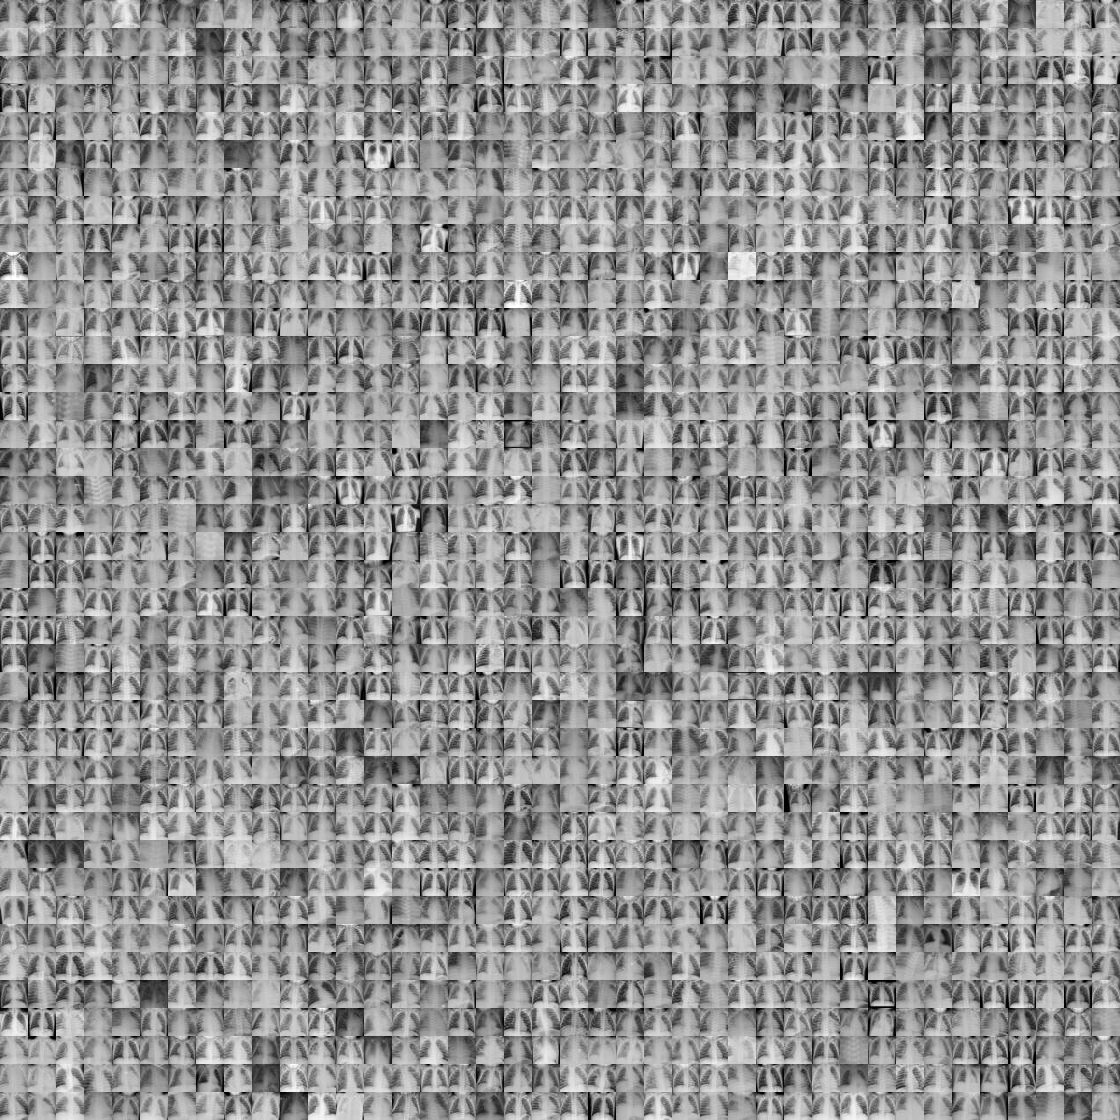

In [8]:
trainX.montage(length=40)

### Set de validacion

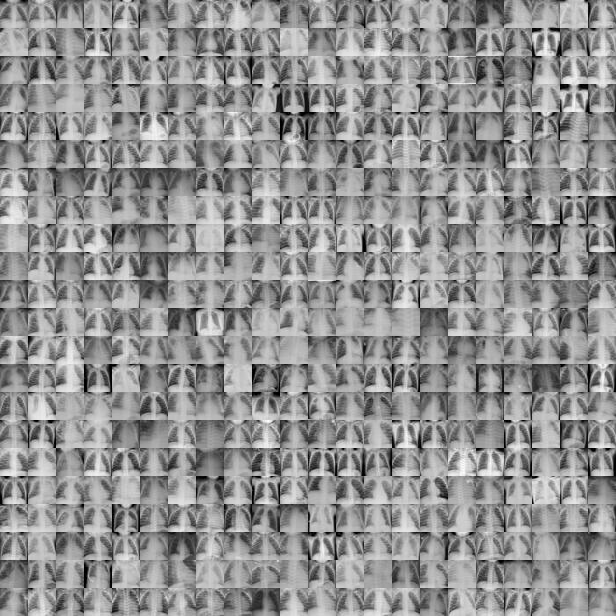

In [9]:
validX.montage(length=22)

### Set de test

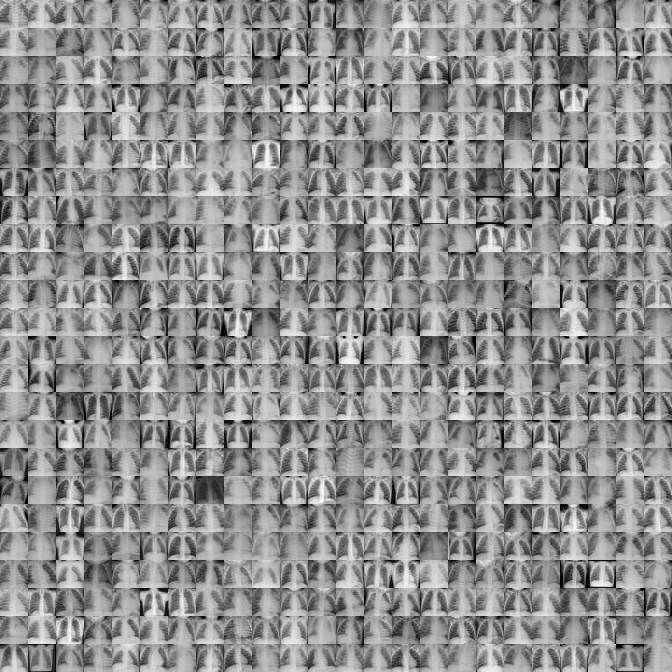

In [10]:
testX.montage(length=24)

# Preprocesamiento de datos

### Normalizamos el valor de la intensidad de la escala de gris en cada pixel

In [11]:
trainX = trainX.imgs / 255.0
validX = validX.imgs / 255.0
testX = testX.imgs / 255.0

In [12]:
(np.max(trainX),np.min(trainX))

(1.0, 0.0)

In [13]:
np.max(validX),np.min(validX)

(1.0, 0.0)

In [14]:
np.max(testX),np.min(testX)

(0.996078431372549, 0.0)

### Ahora se debe convertir los labels a formato OneHotEncoder

In [15]:

trainY_ohe = tensorflow.keras.utils.to_categorical(trainY, dtype='uint8');
validY_ohe = tensorflow.keras.utils.to_categorical(validY, dtype='uint8');
testY_ohe = tensorflow.keras.utils.to_categorical(testY, dtype='uint8');

trainY_ohe[0], validY_ohe[0], testY_ohe[0], trainY[0], validY[0], testY[0]

(array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([1], dtype=uint8),
 array([1], dtype=uint8),
 array([1], dtype=uint8))

# Antes de pasar al Transfer Learning y utilizar modelos pre-entrenados, se debe tomar en cuenta lo siguiente


Como se vio anteriormente las imagenes importadas son de dimensiones 28x28x1, lo que quiere decir que tienen 28 pixeles de ancho y alto y 1 solo canal el cual es en escala de grises. Esto presenta el siguiente inconveniente: Los modelos pre-entrenados tienen unos requisitos para utilizarse. las minimas dimensiones de las imagenes deben ser de 32x32 y se deben trabajar los canales RGB.

Tampoco se puede modificar directamente la capa de entrada del modelo pre-entrenado para que se adapte a nuestros datos de entrada, esto debido a que cuando se reemplaza la capa de entrada del CNN pre-entrenado se esta eliminando la informacion valiosa que las capas subsiguientes esperan recibir. Esto es causa de que las capas posteriores se entrenaron para trabajar con caracteristicas especificas extraidas por las capas anteriores. 

En resumen, reemplazar la capa de entrada del CNN pre-entrenado implica perder el conocimiento aprendido en las capas subsiguientes, ya que necesitarian ser reentrenadas para adaptarse a la nueva entrada. Esto es porque las capas subsiguientes esperan caracteristicas especificas que ya no se proporcionan al cambiar la capa de entrada.

### Como alternativa se redimensionaran las imagenes a 32x32x3, lo que quiere decir que tendran una nueva dimension de 32 pixeles de ancho y alto. Además de tener 3 canales, uno para rojos, uno para verdes y otro para azules(RGB).

### Hay que tomar en cuenta que los valores de los canales color serán identicos, ya que solo se está duplicando la informacion de escala de grises en los color RGB

# Redimensionar imagenes

### Redimensionar con padding

In [16]:
# Tamaño de destino después del padding
desired_size = (32, 32)


#TRAIN

# Crear una matriz para almacenar las imágenes con padding
padded_images = np.zeros((trainX.shape[0], desired_size[0], desired_size[1]))

# Iterar sobre las imágenes y agregar padding a cada una
for i in range(trainX.shape[0]):
    image = trainX[i]
    padding_height = desired_size[0] - image.shape[0]
    padding_width = desired_size[1] - image.shape[1]
    top_padding = padding_height // 2
    bottom_padding = padding_height - top_padding
    left_padding = padding_width // 2
    right_padding = padding_width - left_padding

    padded_image = np.pad(image, ((top_padding, bottom_padding), (left_padding, right_padding)), mode='constant')
    padded_images[i] = padded_image

trainX_padded = padded_images
trainX_padded.shape

#VALID

# Crear una matriz para almacenar las imágenes con padding
padded_images = np.zeros((validX.shape[0], desired_size[0], desired_size[1]))

# Iterar sobre las imágenes y agregar padding a cada una
for i in range(validX.shape[0]):
    image = validX[i]
    padding_height = desired_size[0] - image.shape[0]
    padding_width = desired_size[1] - image.shape[1]
    top_padding = padding_height // 2
    bottom_padding = padding_height - top_padding
    left_padding = padding_width // 2
    right_padding = padding_width - left_padding

    padded_image = np.pad(image, ((top_padding, bottom_padding), (left_padding, right_padding)), mode='constant')

validX_padded = padded_images

#TEST

# Crear una matriz para almacenar las imágenes con padding
padded_images = np.zeros((testX.shape[0], desired_size[0], desired_size[1]))

# Iterar sobre las imágenes y agregar padding a cada una
for i in range(testX.shape[0]):
    image = testX[i]
    padding_height = desired_size[0] - image.shape[0]
    padding_width = desired_size[1] - image.shape[1]
    top_padding = padding_height // 2
    bottom_padding = padding_height - top_padding
    left_padding = padding_width // 2
    right_padding = padding_width - left_padding

    padded_image = np.pad(image, ((top_padding, bottom_padding), (left_padding, right_padding)), mode='constant')
    padded_images[i] = padded_image

testX_padded = padded_images


print(f"El shape del set de entrenamiento, validacion y test con padding quedaron de la siguiente manera:\n \nSet de entrenamiento: {trainX_padded.shape}, Set de validacion: {validX_padded.shape} y  Set de test: {testX_padded.shape}");

El shape del set de entrenamiento, validacion y test con padding quedaron de la siguiente manera:
 
Set de entrenamiento: (4708, 32, 32), Set de validacion: (524, 32, 32) y  Set de test: (624, 32, 32)


### Redimensionar sin padding

In [17]:
#Redimensionar a 32x32 sin padding
trainX_no_padding = []
validX_no_padding = []
testX_no_padding = []

#TRAIN

for i in trainX:
    a = cv2.resize(i, (32,32))
    trainX_no_padding.append(a)

trainX_no_padding = np.array(trainX_no_padding)

#VALID

for i in validX:
    a = cv2.resize(i, (32,32))
    validX_no_padding.append(a)

validX_no_padding = np.array(validX_no_padding)

#TEST

for i in testX:
    a = cv2.resize(i, (32,32))
    testX_no_padding.append(a)

testX_no_padding = np.array(testX_no_padding)

print(f"El shape del set de entrenamiento, validacion y test sin padding quedaron de la siguiente manera:\n \nSet de entrenamiento: {trainX_no_padding.shape}, Set de validacion: {validX_no_padding.shape} y  Set de test: {testX_no_padding.shape}");

El shape del set de entrenamiento, validacion y test sin padding quedaron de la siguiente manera:
 
Set de entrenamiento: (4708, 32, 32), Set de validacion: (524, 32, 32) y  Set de test: (624, 32, 32)


# Visualizar imagenes redimensionadas

### Imagenes redimensionadas con padding

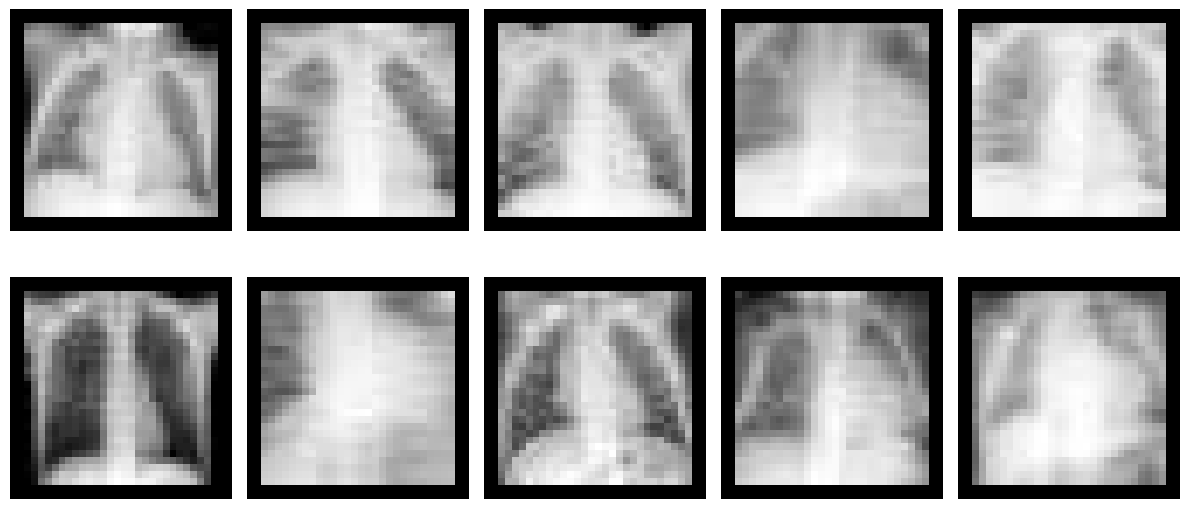

In [18]:
# Obtener las primeras 10 imágenes de entrenamiento
images = trainX_padded[:10]
labels = trainY[:10]

# Crear una figura con 2 filas y 5 columnas para mostrar las imágenes


fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# Iterar sobre las imágenes y mostrarlas en los subplots
for i, ax in enumerate(axes.flatten()):
    image = images[i]
    label = labels[i]
    ax.imshow(image, cmap='gray')
    #ax.set_title(f"Label: {label}")
    ax.axis('off')

# Ajustar el espacio entre las imágenes
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### Imagenes redimensionadas sin padding

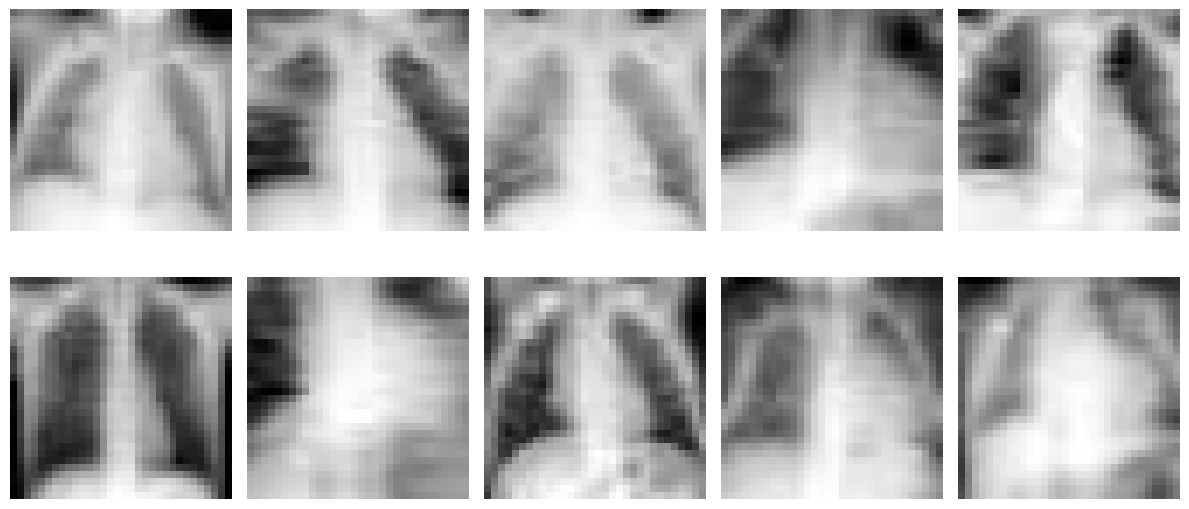

In [19]:
# Obtener las primeras 10 imágenes de entrenamiento
images = trainX_no_padding[:10]
labels = trainY[:10]

# Crear una figura con 2 filas y 5 columnas para mostrar las imágenes
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# Iterar sobre las imágenes y mostrarlas en los subplots
for i, ax in enumerate(axes.flatten()):
    image = images[i]
    label = labels[i]
    ax.imshow(image, cmap='gray')
    #ax.set_title(f"Label: {label}")
    ax.axis('off')

# Ajustar el espacio entre las imágenes
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### Transformar imagenes de escala de grises a RGB

In [20]:
# Convertir imágenes en escala de grises a formato RGB
#Padding

trainX_padded = np.repeat(trainX_padded[..., np.newaxis], 3, axis=-1)

validX_padded = np.repeat(validX_padded[..., np.newaxis], 3, axis=-1)

testX_padded = np.repeat(testX_padded[..., np.newaxis], 3, axis=-1)


#No padded

trainX_no_padding = np.repeat(trainX_no_padding[..., np.newaxis], 3, axis=-1)

validX_no_padding = np.repeat(validX_no_padding[..., np.newaxis], 3, axis=-1)

testX_no_padding = np.repeat(testX_no_padding[..., np.newaxis], 3, axis=-1)

In [21]:
print(f"El shape del set de entrenamiento, validacion y test con padding quedaron de la siguiente manera:\n \nSet de entrenamiento: {trainX_padded.shape}, Set de validacion: {validX_padded.shape} y  Set de test: {testX_padded.shape}");

print(f"\nEl shape del set de entrenamiento, validacion y test sin padding quedaron de la siguiente manera:\n \nSet de entrenamiento: {trainX_no_padding.shape}, Set de validacion: {validX_no_padding.shape} y  Set de test: {testX_no_padding.shape}");

El shape del set de entrenamiento, validacion y test con padding quedaron de la siguiente manera:
 
Set de entrenamiento: (4708, 32, 32, 3), Set de validacion: (524, 32, 32, 3) y  Set de test: (624, 32, 32, 3)

El shape del set de entrenamiento, validacion y test sin padding quedaron de la siguiente manera:
 
Set de entrenamiento: (4708, 32, 32, 3), Set de validacion: (524, 32, 32, 3) y  Set de test: (624, 32, 32, 3)


In [22]:
(trainY_ohe[0], validY_ohe[3]) # (Neumonia, Normal).  [Normal, Neumonia]

(array([0, 1], dtype=uint8), array([1, 0], dtype=uint8))

In [23]:
(trainY[0], validY[3])

(array([1], dtype=uint8), array([0], dtype=uint8))

# Transfer Learning

### Se utilizara la arquitectura de ResNet50 como base para los modelos

In [24]:
base_model = tensorflow.keras.applications.ResNet50(include_top=False,
                                                    weights="imagenet",
                                                    input_shape=(32, 32, 3),
                                                    pooling='max',
                                                    classes=1)

In [25]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

### No se modificaran los pesos y bias del modelo base, por lo que se debera bloquear los parametros entrenables

### Modelos sigmoide

In [26]:
for layer in base_model.layers:
    layer.trainable = False

tensorflow.keras.layers.Flatten = tensorflow.keras.layers.Flatten();
denselayer1 = tensorflow.keras.layers.Dense(100, activation='relu');
output_layer = tensorflow.keras.layers.Dense(1, activation='sigmoid');

modelo_sigmoid_sin_padding = tensorflow.keras.models.Sequential([
    base_model,
    tensorflow.keras.layers.Flatten,
    denselayer1,
    output_layer
])
modelo_sigmoid_padding = tensorflow.keras.models.Sequential([
    base_model,
    tensorflow.keras.layers.Flatten,
    denselayer1,
    output_layer
])


### Compilamos ambos modelos

In [27]:
optimizador = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

In [28]:
modelo_sigmoid_sin_padding.compile(loss='binary_crossentropy', optimizer=optimizador, metrics=["Accuracy"])
modelo_sigmoid_padding.compile(loss='binary_crossentropy', optimizer=optimizador, metrics=["Accuracy"])

### Entrenamos los modelos

In [29]:
tb = TensorBoard(log_dir="./logs/modelo_sigmoide_sin_padding")

In [30]:
trainX_no_padding.shape, validX_no_padding.shape

((4708, 32, 32, 3), (524, 32, 32, 3))

In [31]:
trainY.shape, validY.shape

((4708, 1), (524, 1))

In [32]:
modelo_sigmoid_sin_padding.fit(trainX_no_padding,  trainY, epochs=100, validation_data=(validX_no_padding, validY), callbacks=[tb])

Epoch 1/100
148/148 [==============================] - 36s 165ms/step - loss: 0.5515 - Accuracy: 0.7519 - val_loss: 0.4241 - val_Accuracy: 0.7958
Epoch 2/100
148/148 [==============================] - 16s 110ms/step - loss: 0.3962 - Accuracy: 0.8267 - val_loss: 0.4080 - val_Accuracy: 0.7939
Epoch 3/100
148/148 [==============================] - 17s 112ms/step - loss: 0.3356 - Accuracy: 0.8670 - val_loss: 0.3396 - val_Accuracy: 0.8340
Epoch 4/100
148/148 [==============================] - 14s 97ms/step - loss: 0.3114 - Accuracy: 0.8638 - val_loss: 0.3163 - val_Accuracy: 0.8931
Epoch 5/100
148/148 [==============================] - 16s 111ms/step - loss: 0.2666 - Accuracy: 0.8893 - val_loss: 0.2706 - val_Accuracy: 0.9065
Epoch 6/100
148/148 [==============================] - 16s 109ms/step - loss: 0.2709 - Accuracy: 0.8881 - val_loss: 0.2700 - val_Accuracy: 0.8779
Epoch 7/100
148/148 [==============================] - 13s 85ms/step - loss: 0.2625 - Accuracy: 0.8904 - val_loss: 0.2421 - v

In [40]:
directorio_modelos = './trained_models/modelos_sigmoide/modelo_sigmoide_no_padding'
nombre_del_modelo = 'modelo_sigmoide_sin_padding'
modelo_sigmoid_sin_padding.save(f'{directorio_modelos}/{nombre_del_modelo}')

INFO:tensorflow:Assets written to: ./trained_models/modelos_sigmoide/modelo_sigmoide_no_padding/modelo_sigmoide_sin_padding/assets


INFO:tensorflow:Assets written to: ./trained_models/modelos_sigmoide/modelo_sigmoide_no_padding/modelo_sigmoide_sin_padding/assets


In [ ]:
!tensorboard --logdir=./logs

In [36]:
tb = TensorBoard(log_dir="./logs/modelo_sigmoide_con_padding")

In [37]:
modelo_sigmoid_padding.fit(trainX_padded, trainY, epochs=100, validation_data=(validX_padded, validY), callbacks=[tb])

Epoch 1/100
148/148 [==============================] - 20s 104ms/step - loss: 0.2534 - Accuracy: 0.8934 - val_loss: 2.0402 - val_Accuracy: 0.7424
Epoch 2/100
148/148 [==============================] - 11s 72ms/step - loss: 0.2431 - Accuracy: 0.8976 - val_loss: 1.9450 - val_Accuracy: 0.7424
Epoch 3/100
148/148 [==============================] - 11s 74ms/step - loss: 0.2276 - Accuracy: 0.9087 - val_loss: 1.9293 - val_Accuracy: 0.7424
Epoch 4/100
148/148 [==============================] - 14s 97ms/step - loss: 0.2187 - Accuracy: 0.9112 - val_loss: 1.9786 - val_Accuracy: 0.7424
Epoch 5/100
148/148 [==============================] - 20s 134ms/step - loss: 0.2146 - Accuracy: 0.9136 - val_loss: 1.9716 - val_Accuracy: 0.7424
Epoch 6/100
148/148 [==============================] - 12s 81ms/step - loss: 0.2045 - Accuracy: 0.9125 - val_loss: 1.8228 - val_Accuracy: 0.7424
Epoch 7/100
148/148 [==============================] - 10s 71ms/step - loss: 0.1987 - Accuracy: 0.9189 - val_loss: 2.1327 - val_

In [41]:
directorio_modelos = './trained_models/modelos_sigmoide/modelo_sigmoide_padding/'
nombre_del_modelo = 'modelo_sigmoide_con_padding'
modelo_sigmoid_padding.save(f'{directorio_modelos}/{nombre_del_modelo}')

INFO:tensorflow:Assets written to: ./trained_models/modelos_sigmoide/modelo_sigmoide_padding//modelo_sigmoide_con_padding/assets


INFO:tensorflow:Assets written to: ./trained_models/modelos_sigmoide/modelo_sigmoide_padding//modelo_sigmoide_con_padding/assets


### Modelos Softmax

In [43]:
base_model = tensorflow.keras.applications.ResNet50(include_top=False,
                                                    weights="imagenet",
                                                    input_shape=(32, 32, 3),
                                                    pooling='max',
                                                    classes=2)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

tensorflow.keras.layers.Flatten = tensorflow.keras.layers.Flatten;
denselayer1 = tensorflow.keras.layers.Dense(100, activation='relu');
output_layer = tensorflow.keras.layers.Dense(2, activation='softmax');

modelo_softmax_sin_padding = tensorflow.keras.models.Sequential([
    base_model,
    tensorflow.keras.layers.Flatten,
    denselayer1,
    output_layer
])
modelo_softmax_padding = tensorflow.keras.models.Sequential([
    base_model,
    tensorflow.keras.layers.Flatten,
    denselayer1,
    output_layer
])

### Compilamos los modelos

In [51]:
optimizador = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

In [52]:
modelo_softmax_padding.compile(loss="categorical_crossentropy", optimizer=optimizador, metrics=["Accuracy"])
modelo_softmax_sin_padding.compile(loss="categorical_crossentropy", optimizer=optimizador, metrics=["Accuracy"])

### Entrenamos los modelos

In [53]:
tb = TensorBoard(log_dir="./logs/modelo_softmax_sin_padding")

In [54]:
modelo_softmax_sin_padding.fit(trainX_no_padding, trainY_ohe, epochs=100, validation_data=(validX_no_padding, validY_ohe), callbacks=[tb])

Epoch 1/100
148/148 [==============================] - 14s 73ms/step - loss: 0.5291 - Accuracy: 0.7576 - val_loss: 0.3790 - val_Accuracy: 0.8340
Epoch 2/100
148/148 [==============================] - 8s 56ms/step - loss: 0.3639 - Accuracy: 0.8483 - val_loss: 0.3366 - val_Accuracy: 0.8893
Epoch 3/100
148/148 [==============================] - 9s 58ms/step - loss: 0.3253 - Accuracy: 0.8645 - val_loss: 0.2686 - val_Accuracy: 0.8836
Epoch 4/100
148/148 [==============================] - 12s 83ms/step - loss: 0.2793 - Accuracy: 0.8859 - val_loss: 0.5573 - val_Accuracy: 0.7252
Epoch 5/100
148/148 [==============================] - 9s 59ms/step - loss: 0.2580 - Accuracy: 0.8942 - val_loss: 0.3447 - val_Accuracy: 0.8397
Epoch 6/100
148/148 [==============================] - 9s 62ms/step - loss: 0.2737 - Accuracy: 0.8862 - val_loss: 0.5831 - val_Accuracy: 0.7099
Epoch 7/100
148/148 [==============================] - 9s 61ms/step - loss: 0.2400 - Accuracy: 0.9021 - val_loss: 0.2776 - val_Accurac

In [55]:
directorio_modelos = './trained_models/modelos_softmax/modelo_softmax_no_padding'
nombre_del_modelo = 'modelo_softmax_sin_padding'
modelo_softmax_sin_padding.save(f'{directorio_modelos}/{nombre_del_modelo}')

INFO:tensorflow:Assets written to: ./trained_models/modelos_softmax/modelo_softmax_no_padding/modelo_softmax_sin_padding/assets


INFO:tensorflow:Assets written to: ./trained_models/modelos_softmax/modelo_softmax_no_padding/modelo_softmax_sin_padding/assets


In [56]:
tb = TensorBoard(log_dir="./logs/modelo_softmax_con_padding")

In [57]:
modelo_softmax_padding.fit(trainX_padded, trainY_ohe, epochs=100, validation_data=(validX_padded, validY_ohe), callbacks=[tb])

Epoch 1/100
148/148 [==============================] - 18s 96ms/step - loss: 0.2414 - Accuracy: 0.9004 - val_loss: 2.1891 - val_Accuracy: 0.7424
Epoch 2/100
148/148 [==============================] - 10s 66ms/step - loss: 0.2378 - Accuracy: 0.9002 - val_loss: 1.9735 - val_Accuracy: 0.7424
Epoch 3/100
148/148 [==============================] - 8s 57ms/step - loss: 0.2334 - Accuracy: 0.9023 - val_loss: 2.2086 - val_Accuracy: 0.7424
Epoch 4/100
148/148 [==============================] - 9s 61ms/step - loss: 0.2100 - Accuracy: 0.9129 - val_loss: 2.5464 - val_Accuracy: 0.7424
Epoch 5/100
148/148 [==============================] - 9s 59ms/step - loss: 0.2264 - Accuracy: 0.9031 - val_loss: 2.5640 - val_Accuracy: 0.7424
Epoch 6/100
148/148 [==============================] - 8s 52ms/step - loss: 0.2086 - Accuracy: 0.9108 - val_loss: 2.4404 - val_Accuracy: 0.7424
Epoch 7/100
148/148 [==============================] - 10s 66ms/step - loss: 0.2122 - Accuracy: 0.9114 - val_loss: 2.3450 - val_Accura

In [58]:
directorio_modelos = './trained_models/modelos_softmax/modelo_softmax_padding/'
nombre_del_modelo = 'modelo_softmax_con_padding'
modelo_softmax_padding.save(f'{directorio_modelos}/{nombre_del_modelo}')

INFO:tensorflow:Assets written to: ./trained_models/modelos_softmax/modelo_softmax_padding//modelo_softmax_con_padding/assets


INFO:tensorflow:Assets written to: ./trained_models/modelos_softmax/modelo_softmax_padding//modelo_softmax_con_padding/assets


In [59]:
!tensorboard --logdir=./logs

2023-05-28 22:28:01.857139: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.12.3 at http://localhost:6006/ (Press CTRL+C to quit)
^C


### Cargar modelos

In [ ]:
modelo_sigmoid_padding = tensorflow.keras.models.load_model('trained_models/modelos_sigmoide/modelo_sigmoide_padding/')
modelo_sigmoid_sin_padding = tensorflow.keras.models.load_model('trained_models/modelos_sigmoide/modelo_sigmoide_no_padding/')
modelo_softmax_padding = tensorflow.keras.models.load_model('trained_models/modelos_softmax/modelo_softmax_padding/')
modelo_softmax_sin_padding = tensorflow.keras.models.load_model('trained_models/modelos_softmax/modelo_softmax_no_padding/')

### Matrices de confusion

In [79]:
# Obtener las etiquetas verdaderas y las predicciones de cada modelo

#Sigmoide

predicciones_modelo1 = modelo_sigmoid_sin_padding.predict([validX_no_padding]) # Predicciones del modelo sigmoide sin padding
predicciones_modelo2 = modelo_sigmoid_padding.predict([validX_padded]) # Predicciones del modelo sigmoide con padding

#Softmax

predicciones_modelo3 = modelo_softmax_sin_padding.predict([validX_no_padding])# Predicciones del modelo softmax sin padding
predicciones_modelo4 = modelo_softmax_padding.predict([validX_padded])# Predicciones del modelo softmax con padding

17/17 [==============================] - 1s 67ms/step


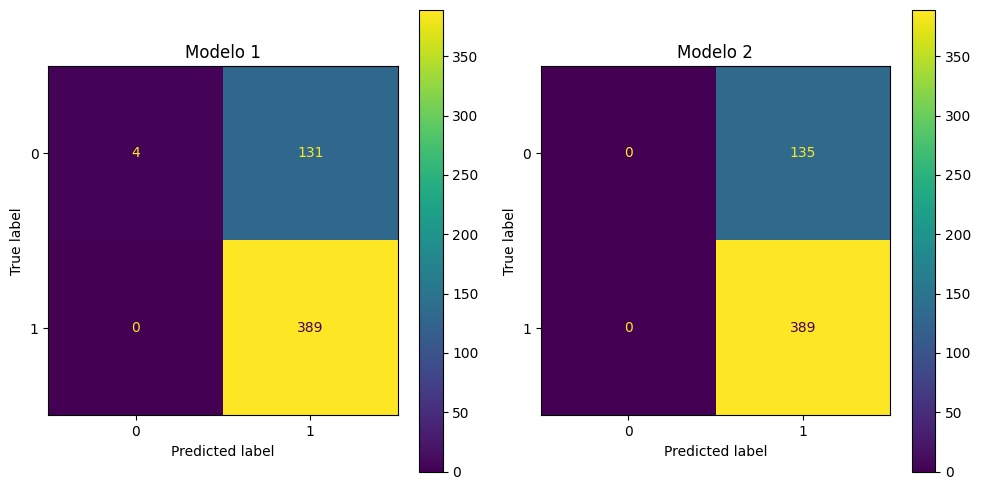

In [82]:
# Establecer el umbral para convertir las predicciones en valores binarios
umbral = 0.5
predicciones_modelo1_bin = (predicciones_modelo1 >= umbral).astype(int)
predicciones_modelo2_bin = (predicciones_modelo2 >= umbral).astype(int)

# Obtener las matrices de confusión de los dos modelos
cm_model1 = confusion_matrix(validY, predicciones_modelo1_bin)
cm_model2 = confusion_matrix(validY, predicciones_modelo2_bin)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Graficar la matriz de confusión del modelo 1
cm_display1 = ConfusionMatrixDisplay(cm_model1).plot(ax=axes[0])
axes[0].set_title('Modelo 1')

# Graficar la matriz de confusión del modelo 2
cm_display2 = ConfusionMatrixDisplay(cm_model2).plot(ax=axes[1])
axes[1].set_title('Modelo 2')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

* $C_0,_0$ -> verdaderos negativos (TN) = 4
* $C_1,_0$ -> falsos negativos (FN) = 0
* $C_1,_1$ -> verdaderos positivos (TP) = 389
* $C_0,_1$ -> falsos positivos (FP) = 131

Modelo 1:

* Verdaderos positivos (TP): 4
* Verdaderos negativos (TN): 131
* Falsos positivos (FP): 0
* Falsos negativos (FN): 389

En el modelo 1, observamos que hay una alta cantidad de falsos negativos (389), lo que indica que el modelo está teniendo dificultades para clasificar correctamente las muestras positivas. Sin embargo, no se han clasificado incorrectamente muestras negativas, ya que no hay falsos positivos en la matriz.

Modelo 2:

* Verdaderos positivos (TP): 0
* Verdaderos negativos (TN): 135
* Falsos positivos (FP): 0
* Falsos negativos (FN): 389

En el modelo 2, también encontramos una alta cantidad de falsos negativos (389), lo que sugiere que este modelo también tiene dificultades para clasificar correctamente las muestras positivas. Al igual que en el modelo 1, no se han clasificado incorrectamente muestras negativas.

En general, ambos modelos muestran dificultades para clasificar correctamente las muestras positivas, lo que se refleja en los altos valores de falsos negativos. Es importante considerar otras métricas de evaluación y explorar posibles mejoras en los modelos, como ajustar hiperparámetros, agregar capas adicionales o aumentar el tamaño del conjunto de datos, para mejorar el rendimiento y reducir los errores de clasificación.